# **Projeto de Machine Learning — Classificação de Cogumelos**

**Autor:** Ademir Guimarães  
**Turma:** Machine Learning Aplicado II  
**Instituição:** *Universidade do Estado do Amazonas*  

---

In [4]:
# Instalações básicas do projeto

!pip install -q pandas numpy matplotlib seaborn scikit-learn

---

## Objetivo

Classificar se um cogumelo é **edible (e)** ou **poisonous (p)** com base nas **22 variáveis categóricas** fornecidas.

O dataset original contém **8124 amostras** e **nenhum atributo numérico**, sendo inteiramente composto por variáveis categóricas.



In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import scipy.stats as ss
from math import sqrt

In [6]:
# Carregando o dataset

DATA_PATH = "data/agaricus-lepiota.data"
df = pd.read_csv(DATA_PATH, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [7]:
# Adicionando nomes às colunas, conforme documento de apoio

column_names = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring",
    "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
    "ring-type", "spore-print-color", "population", "habitat"
]

df.columns = column_names
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [8]:
# EDA básica

print("Número de linhas e colunas:", df.shape)

Número de linhas e colunas: (8124, 23)


In [9]:
print("Duplicatas:", df.duplicated().sum())

Duplicatas: 0


In [10]:
print("Valores faltantes por coluna:\n", df.isna().sum())

Valores faltantes por coluna:
 class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


In [11]:
print("Distribuição da variável alvo:\n", df['class'].value_counts())

Distribuição da variável alvo:
 class
e    4208
p    3916
Name: count, dtype: int64


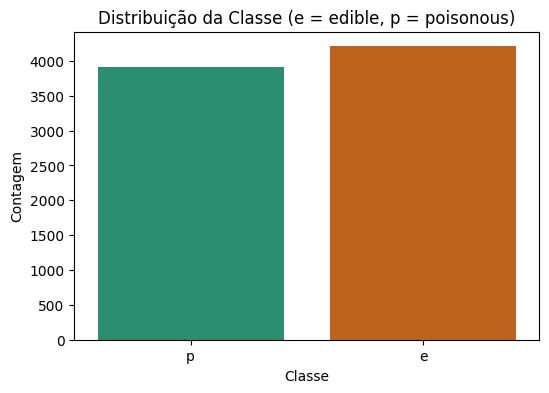

In [12]:
# Plot da distribuição da classe

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="class", hue="class", palette="Dark2")
plt.title("Distribuição da Classe (e = edible, p = poisonous)")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

In [13]:
"""
Cálculo da correlação Cramér V entre variáveis categóricas e a variável alvo.
O V de Cramér varia entre 0 e 1, onde 0 indica nenhuma associação e 1 indica associação perfeita.
"""


def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape
    return sqrt(chi2 / (n * (min(r, k) - 1)))

In [14]:
cramers = {
    col: cramers_v(df[col], df["class"]) for col in df.columns if col != "class"
}

cramer_df = pd.DataFrame.from_dict(
    cramers, orient="index", columns=["Cramér V"])
print("Correlação Cramér V das Features com a Classe")
print(cramer_df.sort_values(by="Cramér V", ascending=False))

Correlação Cramér V das Features com a Classe
                          Cramér V
odor                      0.971005
spore-print-color         0.752645
gill-color                0.680830
ring-type                 0.603271
stalk-surface-above-ring  0.587944
stalk-surface-below-ring  0.574837
gill-size                 0.539758
stalk-color-above-ring    0.524850
stalk-color-below-ring    0.514725
bruises                   0.501280
population                0.487376
habitat                   0.440136
stalk-root                0.406805
gill-spacing              0.348052
cap-shape                 0.245571
cap-color                 0.218427
ring-number               0.214772
cap-surface               0.196925
veil-color                0.153421
gill-attachment           0.128424
stalk-shape               0.101770
veil-type                      NaN


/tmp/ipython-input-1324636903.py:12: RuntimeWarning: invalid value encountered in divide
  return sqrt(chi2 / (n * (min(r, k) - 1)))


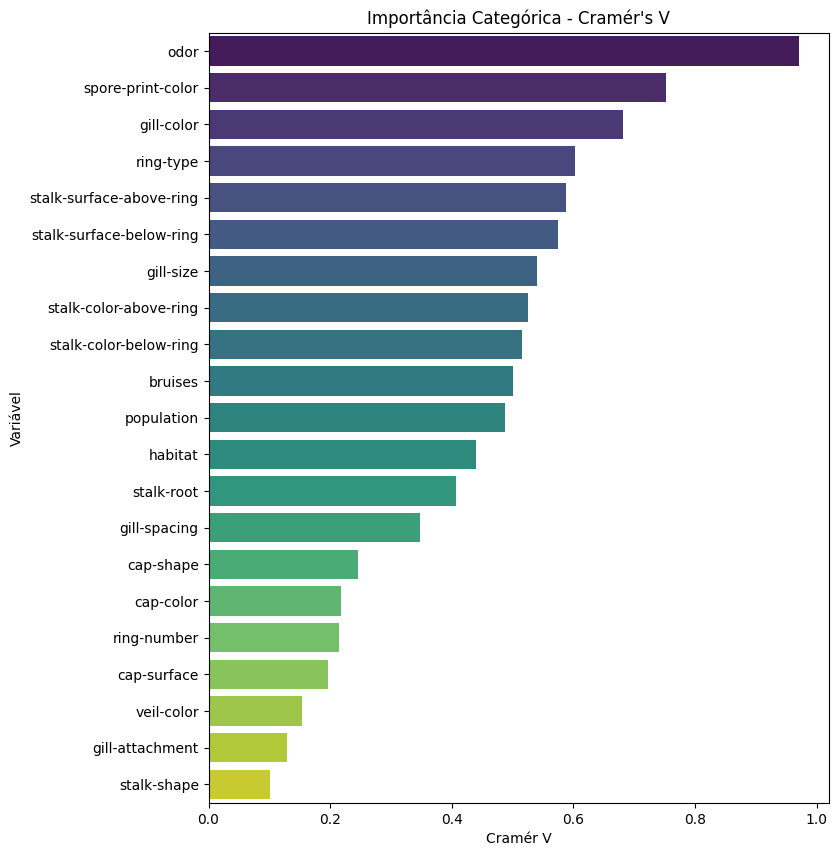

In [15]:
cramer_df = cramer_df.dropna()
ordered = cramer_df.sort_values(by="Cramér V", ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(
    data=ordered,
    x="Cramér V",
    y=ordered.index,
    hue=ordered.index,
    palette="viridis",
    dodge=False,
    legend=False
)

plt.title("Importância Categórica - Cramér's V")
plt.xlabel("Cramér V")
plt.ylabel("Variável")
plt.show()

In [16]:
# Separando features e target (class)

X = df.drop("class", axis=1)
y = df["class"]

In [17]:
# Pré-processamento dos dados
# Utilizando One-Hot Encoding para variáveis categóricas

categorical_features = X.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [18]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [19]:
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_params = {
    "classifier__n_estimators": [200, 300, 400, 500],
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10]
}

rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=10, cv=5, scoring="accuracy", random_state=42, n_jobs=-1
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

print("Random Forest - Melhor Score", rf_search.best_score_)
print("Melhores parâmetros:", rf_search.best_params_)

Random Forest - Melhor Score 1.0
Melhores parâmetros: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 2, 'classifier__max_depth': 10}


In [20]:
lr = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=200, n_jobs=-1))
])

lr_param_dist = {
    "model__C": ss.uniform(0.01, 10),
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

lr_search = RandomizedSearchCV(
    lr, lr_param_dist, n_iter=10, cv=5, scoring="accuracy", random_state=42, n_jobs=-1
)

lr_search.fit(X_train, y_train)
lr_best = lr_search.best_estimator_

print("Logistic Regression - Melhor Score", lr_search.best_score_)
print("Melhores parâmetros:", lr_search.best_params_)

Logistic Regression - Melhor Score 1.0
Melhores parâmetros: {'model__C': np.float64(3.7554011884736247), 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [21]:
SVC(probability=True)

svm = Pipeline([
    ("prep", preprocessor),
    ("classifier", SVC(kernel="rbf", probability=True))
])

svm_param_dist = {
    "classifier__C": ss.loguniform(1e-2, 1e2),
    "classifier__gamma": ss.loguniform(1e-3, 1e0)
}

svm_search = RandomizedSearchCV(
    svm, svm_param_dist, n_iter=10, cv=5, scoring="accuracy",
    random_state=42, n_jobs=-1
)

svm_search.fit(X_train, y_train)
svm_best = svm_search.best_estimator_

print("SVM - Melhor Score", svm_search.best_score_)
print("Melhores parâmetros:", svm_search.best_params_)

SVM - Melhor Score 1.0
Melhores parâmetros: {'classifier__C': np.float64(0.31489116479568624), 'classifier__gamma': np.float64(0.711447600934342)}


In [22]:
mlp_pipe = Pipeline([
    ("prep", preprocessor),
    ("classifier", MLPClassifier(max_iter=500, random_state=42))
])

mlp_params = {
    "classifier__hidden_layer_sizes": [
        (50,), (100,), (50, 50), (100, 50), (100, 100)
    ],
    "classifier__solver": ["adam", "lbfgs"],
    "classifier__learning_rate_init": [1e-4, 1e-3, 1e-2]
}

mlp_search = RandomizedSearchCV(
    mlp_pipe, mlp_params, n_iter=10, cv=5, scoring="accuracy",
    random_state=42, n_jobs=-1
)

mlp_search.fit(X_train, y_train)
mlp_best = mlp_search.best_estimator_

RandomForest
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       843
           p       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



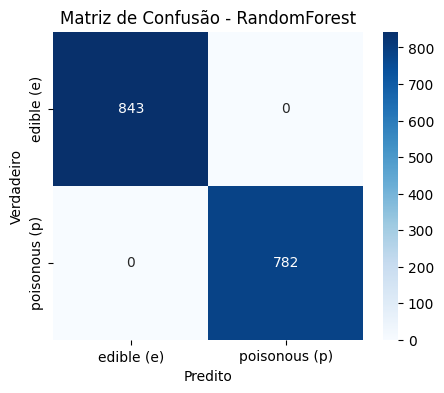

ROC AUC: 1.0


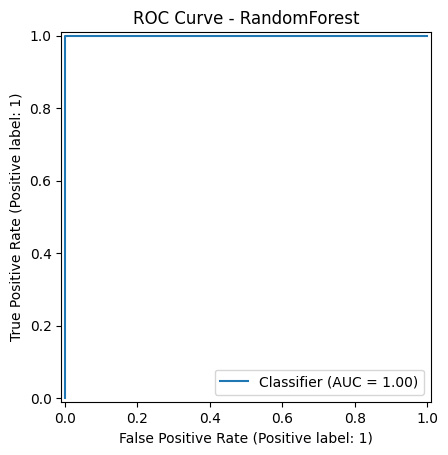

LogisticRegression
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       843
           p       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



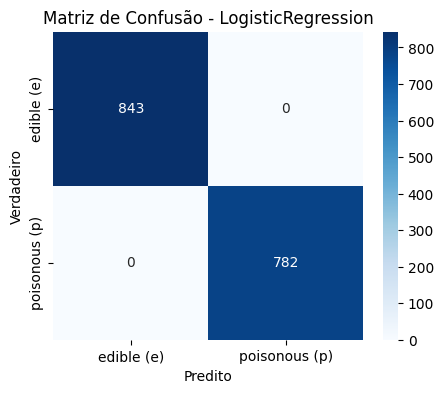

ROC AUC: 1.0


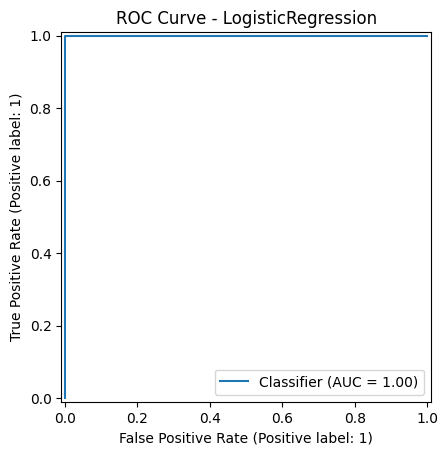

SVM
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       843
           p       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



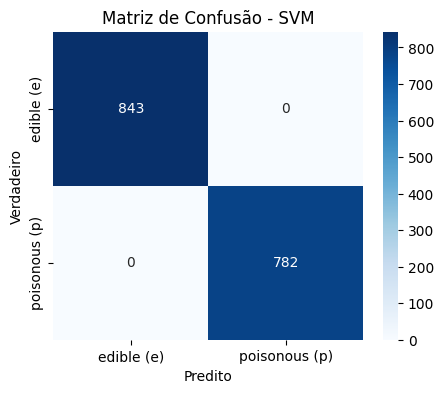

ROC AUC: 1.0


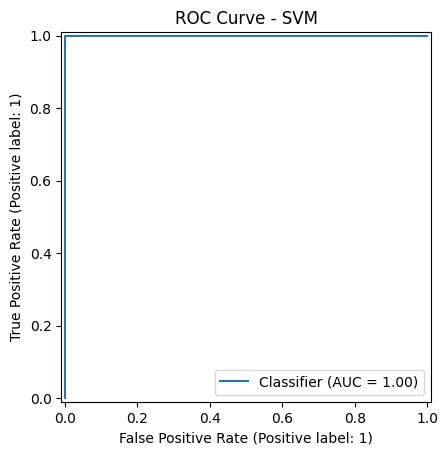

In [25]:
resultados = []

for nome, modelo in modelos.items():
    print(f"{nome}")
    y_pred = modelo.predict(X_test)

    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
        auc = roc_auc_score((y_test == "p").astype(int), y_proba)
    else:
        y_proba = None
        auc = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label="p")
    rec = recall_score(y_test, y_pred, pos_label="p")
    f1 = f1_score(y_test, y_pred, pos_label="p")

    resultados.append({
        "Modelo": nome,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC AUC": auc
    })

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=["e", "p"])
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=["edible (e)", "poisonous (p)"],
        yticklabels=["edible (e)", "poisonous (p)"],
        cmap="Blues"
    )
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()

    if y_proba is not None:
        print("ROC AUC:", auc)

        RocCurveDisplay.from_predictions(
            (y_test == "p").astype(int), y_proba
        )
        plt.title(f"ROC Curve - {nome}")
        plt.show()

In [26]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values("Accuracy", ascending=False)

print("Resultados Finais")
df_resultados

Resultados Finais


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,RandomForest,1.0,1.0,1.0,1.0,1.0
1,LogisticRegression,1.0,1.0,1.0,1.0,1.0
2,SVM,1.0,1.0,1.0,1.0,1.0


---

## Nota do Autor

Ao encontrar todos os resultados em **1.00**, pensei que havia algo errado.  
Por isso, ao fim, voltei à plataforma da **UCI** para revisar o dataset e observei que os resultados com **100 pontos percentuais de acurácia e precisão** são realmente o *baseline* típico desse conjunto para a maior parte dos modelos.

A única exceção é o **LogisticRegression**, que apresenta alguma oscilação. Ainda assim, ele também pode atingir **100 p.p.** dependendo da configuração e do pré-processamento.


In [27]:
!sudo apt-get update -y
!sudo apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic
!pip install nbconvert

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,835 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubunt

In [28]:
!jupyter nbconvert --to pdf --output notebook.pdf "main.ipynb"


[NbConvertApp] WARNING | pattern 'main.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execut